# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
data.info()
#data.describe()
#data.hist(figsize=(15, 20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Предобработка данных

**2.1 ПРОПУСКИ:**

In [2]:
# ceiling_height(высота потолков)
for row in data['floors_total'].unique():
    data.loc[(data['floors_total'] == row) & (data['ceiling_height'].isna()),'ceiling_height'] =\
    data.loc[(data['floors_total'] == row), 'ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].isna().sum()

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0

Пропуски заполнила значением медианы с учетом этажности дома через цикл, так как скорей всего в пятиэтажных домах потолки выше (хрущевки, сталинки, брежневки)

Причины, которые могли привести к пропускам:

1/ Человеческий фактор (забыли/попустили/не считали информацию важной)

2/ Технический фактор (сбой при передаче данных на любом этапе)

In [3]:
# floors_total(всего этажей в доме)
data = data.dropna(subset=['floors_total']).reset_index(drop = True)
data['floors_total'].isna().sum()

0

In [4]:
# код ревьюера
data[data['floors_total'] < data['floor']].shape[0]

0

Пропуски заполнила значением медианы с учетом локаций через цикл, так как скорей всего этажность построек в одном населенном пункте схожее

Причины, которые могли привести к пропускам:

1/ Человеческий фактор (забыли/попустили/не считали информацию важной)

2/ Технический фактор (сбой при передаче данных на любом этапе)


In [5]:
#living_area(жилая площадь в квадратных метрах)
data['coef_liv'] = data['living_area']/data['total_area']
rooms_coeff_living = data.query('living_area > 0').pivot_table(index='rooms', values='coef_liv')
for row in data['rooms'].unique():
    data.loc[(data['rooms']== row) & (data['living_area'].isna()),'living_area'] =\
    data.loc[(data['rooms']== row) & (data['living_area'].isna()), 'total_area'] * rooms_coeff_living.loc[row, 'coef_liv']
data['living_area'].isna().sum()

0

Пропуски заполнила с учетом усредненного коэффициента жилой площади по кол-ву комнат, так как коэффициент более прозрачная величина для определения значения. 
Жилая плошадь одной комнаты скорее всего будет отличаться от жилой площади с двумя комнатами, при этом коэффициент, умноженный на общую площадь, показывает более реалистичную картину, чем просто вычисление значения медианы жилой площади по кол-ву комнат.

Причины, которые могли привести к пропускам:

1/ Человеческий фактор (забыли/попустили/не считали информацию важной)

2/ Технический фактор (сбой при передаче данных на любом этапе)

In [6]:
# is_apartment(апартаменты да/нет)
data['is_apartment']= data['is_apartment'].fillna(False)
data['is_apartment'].isna().sum()

0

In [7]:
bool('False') #код ревьюера

True

Пропуски заполнила значением False, так как скорей всего пользователь посчитал, что пустота является фактом подтверждения отсутствия признака Апартаменты  

In [8]:
# kitchen_area(площадь кухни в квадратных метрах)
data['coef_kit'] = data['kitchen_area']/data['total_area']
rooms_coeff_kitchen = data.query('kitchen_area > 0').pivot_table(index='rooms', values='coef_kit')
for row in rooms_coeff_kitchen.index:
    data.loc[(data['rooms'] == row) & (data['kitchen_area'].isna()), 'kitchen_area'] =\
    data.loc[(data['rooms'] == row) & (data['kitchen_area'].isna()), 'total_area'] * rooms_coeff_kitchen.loc[row, 'coef_kit']
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] - data['living_area'])
data['kitchen_area'].isna().sum()

0

Пропуски заполнила с учетом усредненного коэффициента площади кухни по кол-ву комнат, так как коэффициент более прозрачная величина для определения значения. 
Площадь кухни одной комнаты скорее всего будет отличаться от площади кухни с двумя комнатами, при этом коэффициент, умноженный на общую площадь, показывает более реалистичную картину, чем просто вычисление значения медианы площади кухни по кол-ву комнат.

Причины, которые могли привести к пропускам:

1/ Человеческий фактор (забыли/попустили/не считали информацию важной)

2/ Технический фактор (сбой при передаче данных на любом этапе)

In [9]:
#balcony(число балконов)
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().sum()

0

Пропуски заполнила значением = 0, так как скорей всего у пользователя отсутствует балкон (не заполнял значение) 

In [10]:
# locality_name (название населённого пункта)
data = data.dropna(subset=['locality_name']).reset_index(drop = True)
data['locality_name'].isna().sum()

0

Пропуски удалила, так как локация самый важный показатель для анализа. Его отсутствие невозможно заполнить реалистичным значением

In [11]:
#airports_nearest(расстояние до ближайшего аэропорта в метрах)
def funmedian (group, name):
    air_median = data.groupby(group)[name].median()
    for fl in data[group].unique():
        data.loc[(data[group] == fl), name] =\
        data.loc[(data[group] == fl), name].fillna (air_median[fl])
    return data[name].isna().sum()

funmedian ('locality_name', 'airports_nearest')
data['airports_nearest'] = data['airports_nearest'].fillna(77777777)
data['airports_nearest'].isna().sum()

0

Обратите внимание, в данном решении уже использовала функцию для заполнения пропусков иным методом.
Пропуски заполнила значением медианы по локации, так как скорей всего удаленность аэропорта в одном населенном пункте схожее.
А также добавила маркер 77777777 для значений, по которым расчет выше не сработал, таким образом в дальнейшем отфильтрую данные при необходимости 

Причины, которые могли привести к пропускам:

1/ Человеческий фактор (забыли/попустили/не считали информацию важной)

2/ Технический фактор (сбой при передаче данных на любом этапе)

In [12]:
#cityCenters_nearest(расстояние до центра города)
funmedian ('locality_name', 'cityCenters_nearest')
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(77777777)
data['cityCenters_nearest'].isna().sum()

0

Пропуски заполнила значением медианы по локации, так как скорей всего удаленность центра в одном населенном пункте схожее.
А также добавила маркер 77777777 для значений, по которым расчет выше не сработал, таким образом в дальнейшем отфильтрую данные при необходимости 

Причины, которые могли привести к пропускам:

1/ Человеческий фактор (забыли/попустили/не считали информацию важной)

2/ Технический фактор (сбой при передаче данных на любом этапе)

In [13]:
#parks_around3000(число парков в радиусе 3 км)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_around3000'].isna().sum()

0

Пропуски заполнила значением = 0

Причины, которые могли привести к пропускам:

1/ Человеческий фактор (забыли/попустили/не считали информацию важной)

2/ Технический фактор (сбой при передаче данных на любом этапе)

In [14]:
#parks_nearest(расстояние до ближайшего парка)
funmedian ('locality_name', 'parks_nearest')
data['parks_nearest'] = data['parks_nearest'].fillna(77777777)
data['parks_nearest'].isna().sum()

0

Пропуски заполнила значением медианы по локации, так как скорей всего удаленность парка в одном населенном пункте схожее. А также добавила маркер 77777777 для значений, по которым расчет выше не сработал, таким образом в дальнейшем отфильтрую данные при необходимости

Причины, которые могли привести к пропускам:

1/ Человеческий фактор (забыли/попустили/не считали информацию важной)

2/ Технический фактор (сбой при передаче данных на любом этапе)

In [15]:
#ponds_around3000(число водоёмов в радиусе 3 км)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_around3000'].isna().sum()

0

Пропуски заполнила значением = 0

Причины, которые могли привести к пропускам:

1/ Человеческий фактор (забыли/попустили/не считали информацию важной)

2/ Технический фактор (сбой при передаче данных на любом этапе)

In [16]:
#ponds_nearest(расстояние до ближайшего водоёма)
funmedian ('locality_name', 'ponds_nearest')
data['ponds_nearest'] = data['ponds_nearest'].fillna(77777777)
data['ponds_nearest'].isna().sum()

0

Пропуски заполнила значением медианы по локации, так как скорей всего удаленность в одном населенном пункте схожее. А также добавила маркер 77777777 для значений, по которым расчет выше не сработал, таким образом в дальнейшем отфильтрую данные при необходимости

Причины, которые могли привести к пропускам:

1/ Человеческий фактор (забыли/попустили/не считали информацию важной)

2/ Технический фактор (сбой при передаче данных на любом этапе)

In [17]:
#days_exposition(сколько дней было размещено объявление (от публикации до снятия))
data['days_exposition'] = data['days_exposition'].fillna(77777777)
data['days_exposition'].isna().sum()

0

Пропуски заполнила маркером 77777777 таким образом в дальнейшем отфильтрую данные при необходимости.
Пропуски связаны с тем, что квартиры еще не проданы

In [18]:
#посмотрела на общую ситуацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

**2.2 ИЗМЕНЕНИЕ ТИПА ДАННЫХ**

In [19]:
#first_day_exposition(дата публикации)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Очевидно, что дата должна быть в формате date

In [20]:
#last_price(цена)
#floors_total(всего этажей в доме)
#balcony(число балконов)
#parks_around3000(число парков в радиусе 3 км)
#ponds_around3000(число водоёмов в радиусе 3 км)
#days_exposition(сколько дней было размещено объявление (от публикации до снятия))

for i in ['last_price','floors_total', 'balcony', 'parks_around3000','ponds_around3000', 'days_exposition']:
    data[i] = data[i].astype('int64')
    
#total_area(общая площадь квартиры в квадратных метрах)
#ceiling_height(высота потолков)
#living_area(жилая площадь в квадратных метрах)
#kitchen_area(площадь кухни в квадратных метрах)

for i in ['total_area','ceiling_height','living_area','kitchen_area']:
    data[i] = data[i].round(1)   

Через цикл преобразовала числовые значения в int, так как данные  после запятой не несут ценности и  сократила кол-во символов до одного после запятой, где необходимо - для читабельности данных

**2.3 ДУБЛИКАТЫ**

In [21]:
#locality_name(название населённого пункта)
data['locality_name'].value_counts()
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex = True)
data['locality_name'] = data['locality_name'].str.replace('деревня', ' ', regex = True)
data['locality_name'] = data['locality_name'].str.replace('поселок', ' ', regex = True)
data['locality_name'] = data['locality_name'].str.replace('городского типа', ' ', regex = True)
data['locality_name'] = data['locality_name'].str.replace('село', ' ', regex = True)
data['locality_name'] = data['locality_name'].str.replace('городской', ' ', regex = True)
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество', ' ', regex = True)
data['locality_name'] = data['locality_name'].str.strip()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

**2.4 ВЫБИВАЮЩИЕСЯ ЗНАЧЕНИЯ**

In [22]:
# ceiling_height(высота потолков)
data.loc[data['ceiling_height'] >= 10.00, 'ceiling_height'] =\
data.loc[data['ceiling_height'] >= 10.00, 'ceiling_height']/10
data['ceiling_height'].value_counts().head(10)
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,coef_liv,coef_kit
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,2.356500e+04,2.356500e+04,23565.000000,2.356500e+04,23565.000000,2.356500e+04,2.356500e+04,21700.000000,21343.000000
mean,9.878421,6.540058e+06,60.322813,2.070656,2.720323,10.675875,34.664210,5.878124,10.521252,0.593677,1.795081e+07,1.793958e+07,0.468831,1.975753e+07,0.589900,1.820960e+07,1.046624e+07,0.564937,0.187340
std,5.681156,1.091093e+07,35.657072,1.078591,0.248352,6.594823,22.784207,4.871485,5.851021,0.960660,3.274547e+07,3.275162e+07,0.748403,3.385790e+07,0.883966,3.293521e+07,2.654273e+07,0.105310,0.072979
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000e+00,1.810000e+02,0.000000,1.000000e+00,0.000000,1.300000e+01,1.000000e+00,0.021583,0.025381
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.800000,2.000000,7.100000,0.000000,2.115600e+04,1.093500e+04,0.000000,4.600000e+02,0.000000,5.040000e+02,4.500000e+01,0.495444,0.133333
50%,9.000000,4.646000e+06,52.000000,2.000000,2.600000,9.000000,30.000000,4.000000,9.200000,0.000000,3.336700e+04,1.495800e+04,0.000000,4.600000e+02,0.000000,5.040000e+02,1.240000e+02,0.568210,0.172363
75%,14.000000,6.790000e+06,69.700000,3.000000,2.800000,16.000000,42.300000,8.000000,11.900000,1.000000,5.372400e+04,3.451700e+04,1.000000,7.777778e+07,1.000000,9.930000e+02,3.900000e+02,0.637913,0.232432
max,50.000000,7.630000e+08,900.000000,19.000000,10.000000,60.000000,415.200000,33.000000,123.500000,5.000000,7.777778e+07,7.777778e+07,3.000000,7.777778e+07,3.000000,7.777778e+07,7.777778e+07,1.000000,0.787879


### Посчитайте и добавьте в таблицу новые столбцы

In [23]:
#цена одного квадратного метра
data['price_one_meter'] = (data['last_price']/data['total_area']).round(1)
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,coef_liv,coef_kit,price_one_meter
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,18863.0,16028.0,1,482.0,2,755.0,77777777,0.472222,0.231481,120370.4
1,7,3350000,40.4,2018-12-04,1,2.8,11,18.6,1,False,...,12817.0,18603.0,0,77777777.0,0,584.5,81,0.460396,0.272277,82920.8
2,10,5196000,56.0,2015-08-20,2,2.6,5,34.3,4,False,...,21741.0,13933.0,1,90.0,2,574.0,558,0.612500,0.148214,92785.7
3,0,64900000,159.0,2015-07-24,3,2.6,14,99.5,9,False,...,28098.0,6800.0,2,84.0,3,234.0,424,NaN,NaN,408176.1
4,2,10000000,100.0,2018-06-19,2,3.0,14,32.0,13,False,...,31856.0,8098.0,2,112.0,1,48.0,121,0.320000,0.410000,100000.0
5,10,2890000,30.4,2018-09-10,1,2.6,12,14.4,5,False,...,77777777.0,77777777.0,0,77777777.0,0,77777777.0,55,0.473684,0.299342,95065.8
6,6,3700000,37.3,2017-11-02,1,2.7,26,10.6,6,False,...,52996.0,19143.0,0,733.0,0,593.0,155,0.284182,0.386059,99195.7
7,5,7915000,71.6,2019-04-18,2,2.8,24,41.5,22,False,...,23982.0,11634.0,0,460.0,0,504.0,77777777,NaN,0.263966,110544.7
8,20,2900000,33.2,2018-05-23,1,2.7,27,15.4,26,False,...,77777777.0,77777777.0,0,77777777.0,0,77777777.0,189,0.465320,0.265682,87349.4
9,18,5400000,61.0,2017-02-26,3,2.5,9,43.6,7,False,...,50898.0,15008.0,0,460.0,0,504.0,289,0.714754,0.106557,88524.6


In [24]:
#день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
data['day_week'] = data['first_day_exposition'].dt.dayofweek
week = {0: '0.понедельник', 1: '1.вторник', 2: '2.среда', 3: '3.четверг', 4: '4.пятница', 5: '5.суббота', 6: '6.воскресенье'}
data['day_week'] = data['day_week'].map(week)
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
data.head(10)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,coef_liv,coef_kit,price_one_meter,day_week,month,year
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,482.0,2,755.0,77777777,0.472222,0.231481,120370.4,3.четверг,3,2019
1,7,3350000,40.4,2018-12-04,1,2.8,11,18.6,1,False,...,77777777.0,0,584.5,81,0.460396,0.272277,82920.8,1.вторник,12,2018
2,10,5196000,56.0,2015-08-20,2,2.6,5,34.3,4,False,...,90.0,2,574.0,558,0.612500,0.148214,92785.7,3.четверг,8,2015
3,0,64900000,159.0,2015-07-24,3,2.6,14,99.5,9,False,...,84.0,3,234.0,424,NaN,NaN,408176.1,4.пятница,7,2015
4,2,10000000,100.0,2018-06-19,2,3.0,14,32.0,13,False,...,112.0,1,48.0,121,0.320000,0.410000,100000.0,1.вторник,6,2018
5,10,2890000,30.4,2018-09-10,1,2.6,12,14.4,5,False,...,77777777.0,0,77777777.0,55,0.473684,0.299342,95065.8,0.понедельник,9,2018
6,6,3700000,37.3,2017-11-02,1,2.7,26,10.6,6,False,...,733.0,0,593.0,155,0.284182,0.386059,99195.7,3.четверг,11,2017
7,5,7915000,71.6,2019-04-18,2,2.8,24,41.5,22,False,...,460.0,0,504.0,77777777,NaN,0.263966,110544.7,3.четверг,4,2019
8,20,2900000,33.2,2018-05-23,1,2.7,27,15.4,26,False,...,77777777.0,0,77777777.0,189,0.465320,0.265682,87349.4,2.среда,5,2018
9,18,5400000,61.0,2017-02-26,3,2.5,9,43.6,7,False,...,460.0,0,504.0,289,0.714754,0.106557,88524.6,6.воскресенье,2,2017


In [25]:
#тип этажа квартиры (значения — «первый», «последний», «другой»)
def category_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
         return 'другой'
data['category_floor'] = data.apply(category_floor, axis=1)
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,coef_liv,coef_kit,price_one_meter,day_week,month,year,category_floor
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,2,755.0,77777777,0.472222,0.231481,120370.4,3.четверг,3,2019,другой
1,7,3350000,40.4,2018-12-04,1,2.8,11,18.6,1,False,...,0,584.5,81,0.460396,0.272277,82920.8,1.вторник,12,2018,первый
2,10,5196000,56.0,2015-08-20,2,2.6,5,34.3,4,False,...,2,574.0,558,0.612500,0.148214,92785.7,3.четверг,8,2015,другой
3,0,64900000,159.0,2015-07-24,3,2.6,14,99.5,9,False,...,3,234.0,424,NaN,NaN,408176.1,4.пятница,7,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.0,14,32.0,13,False,...,1,48.0,121,0.320000,0.410000,100000.0,1.вторник,6,2018,другой
5,10,2890000,30.4,2018-09-10,1,2.6,12,14.4,5,False,...,0,77777777.0,55,0.473684,0.299342,95065.8,0.понедельник,9,2018,другой
6,6,3700000,37.3,2017-11-02,1,2.7,26,10.6,6,False,...,0,593.0,155,0.284182,0.386059,99195.7,3.четверг,11,2017,другой
7,5,7915000,71.6,2019-04-18,2,2.8,24,41.5,22,False,...,0,504.0,77777777,NaN,0.263966,110544.7,3.четверг,4,2019,другой
8,20,2900000,33.2,2018-05-23,1,2.7,27,15.4,26,False,...,0,77777777.0,189,0.465320,0.265682,87349.4,2.среда,5,2018,другой
9,18,5400000,61.0,2017-02-26,3,2.5,9,43.6,7,False,...,0,504.0,289,0.714754,0.106557,88524.6,6.воскресенье,2,2017,другой


In [26]:
#расстояние до центра города в километрах (переведите из м в км и округлите до целых значений)
data['cityCenters_nearest'] = (data['cityCenters_nearest'] * 0.001).round(1)
data['cityCenters_nearest'].sort_values()

13616        0.2
8571         0.2
1177         0.2
21911        0.3
1927         0.3
          ...   
7349     77777.8
17784    77777.8
7355     77777.8
7334     77777.8
23564    77777.8
Name: cityCenters_nearest, Length: 23565, dtype: float64

### Проведите исследовательский анализ данных

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

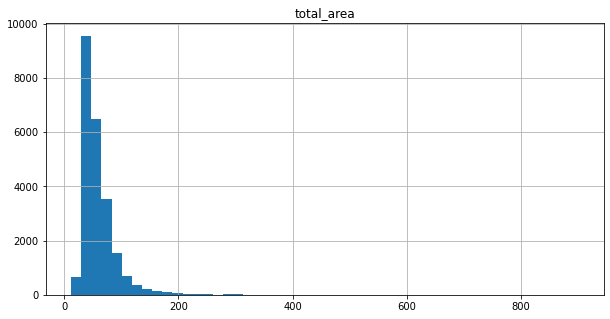

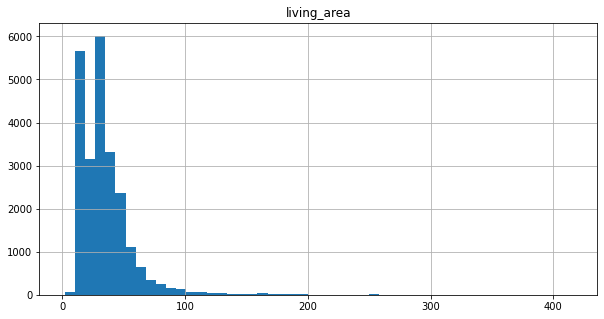

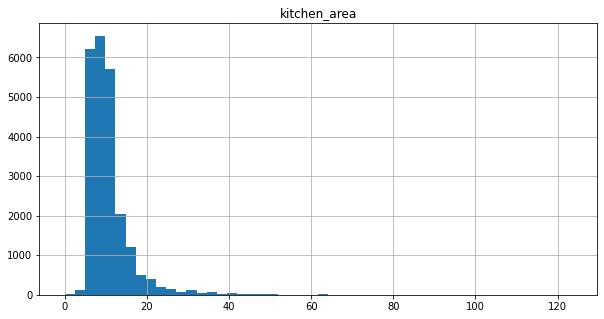

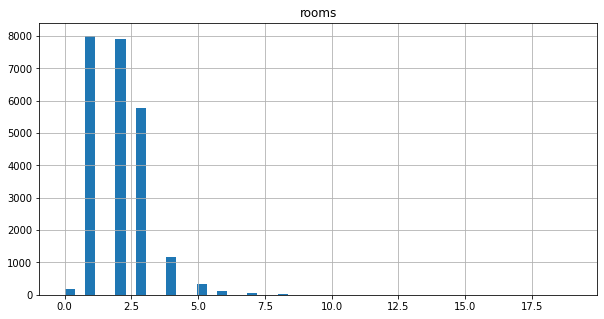

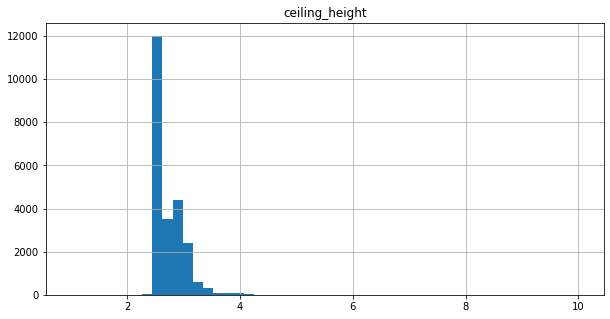

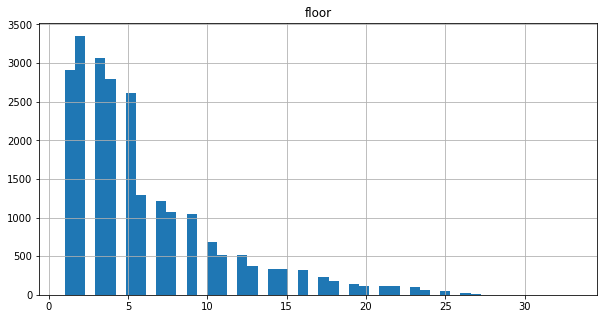

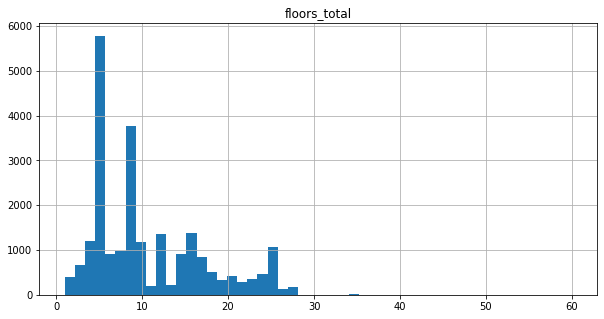

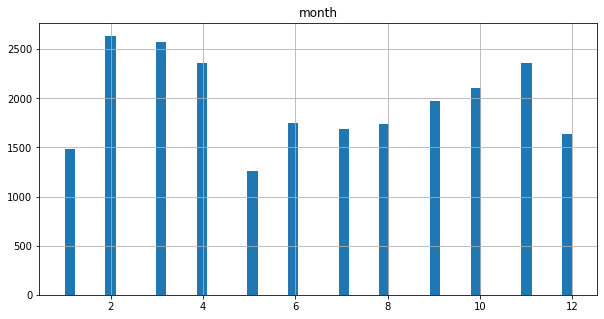

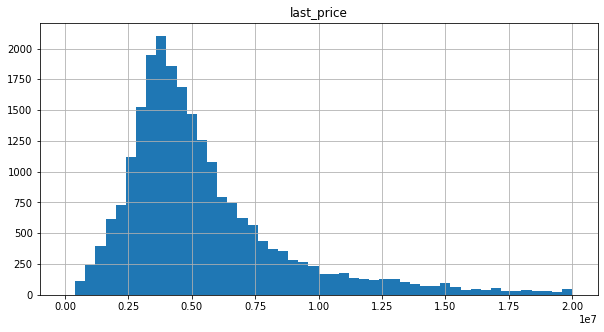

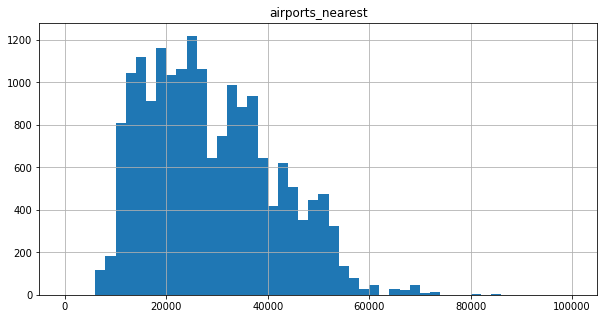

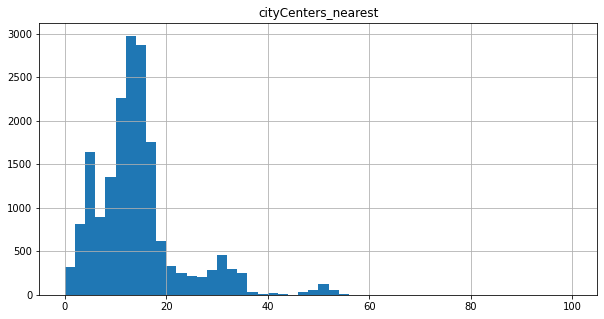

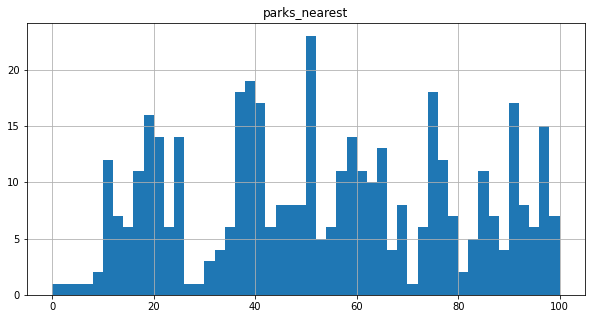

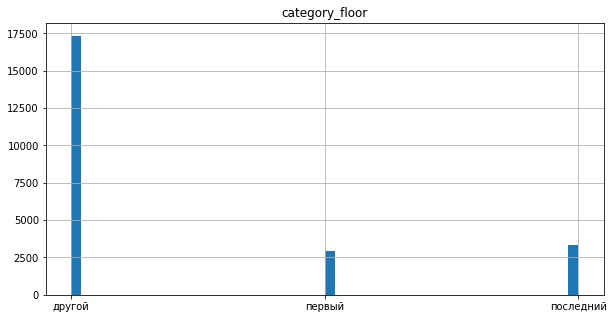

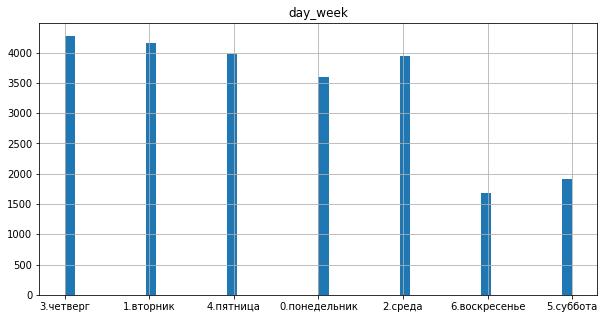

In [28]:
#построение графиков через словарь   
dict_params = {'total_area':[50, (0,500)] ,'living_area':[50, (0,500)], 'kitchen_area':[50, (0,300)], 
               'rooms':[50, (0,20)], 'ceiling_height':[50, (0,15)], 'floor':[50, (0,100)],
               'floors_total':[50, (0,100)],'month':[50, (0,12)]}

for column in dict_params.keys():
    data[column].hist(bins=dict_params[column][0], figsize=(10,5))
    plt.title(column)
    plt.show()

#просто гистограмма
data['last_price'].hist(bins=50, figsize=(10,5),range=(0, 20000000))
plt.title('last_price')
plt.show()

data['airports_nearest'].hist(bins=50, figsize=(10,5), range=(0, 100000))
plt.title('airports_nearest')
plt.show()

#построение графиков через список    
list_params = ['cityCenters_nearest', 'parks_nearest']
for column in list_params:
    data[column].hist(bins=50, figsize=(10,5), range=(0, 100))
    plt.title(column)
    plt.show()

#построение графиков через список_категориальные значения
list_categorical = ['category_floor', 'day_week']
for column in list_categorical:
    data[column].hist(bins=50, figsize=(10,5))
    plt.title(column)
    plt.show()


Общие графики:
Общая площадь: большая часть квартир имеет метраж от 30 до 100 кв.м., пик приходится на 50 кв.м. Есть квартиры и по 800м, но это единичные выбросы

Жилая площадь: большая часть жилой площади имеет метраж от 10 до 100 кв.м., наблюдаем 2 пика на 20 кв.м. и 40 кв.м. На самом деле подозрительно

Площадь кухни: большая часть площади кухни имеет метраж от 5 до 20 кв.м. пик приходится 10 кв.м. 

Комнаты: 2/3 квартир имеют 1 или 2 комнаты, чуть меньший процент имеют 3 комнаты и небольшое количество - 4. Есть и квартиры, имеющие больше комнат, но их единицы

Высота потолков: квартиры, в большинстве своем, имеют потолки от 2,5-2,75м (самый популярный вариант) до 3,2м. Остальные случаи - эксклюзивы

Этаж квартиры: самый популярный этаж продажи - это первый и второй до пятого этажа, скорей всего связано с тем, что в принципе продают большинство квартир в пятиэтажном доме.

Кол-во этажей: гипотеза, что большинство квартир продают в пятиэтажном доме подтвердилась, теперь все ясно

Месяц: в принципе во всех месяцах выставляют квартиры на продажу, но большинство все таки с февраля по апрель. И логично самые провальные месяцы декабрь, январь, май - гуляют люди

Цена: цена в среднем в промежутке от 2 до 5 млн.

Расстояние до аэропорта: в среднем удаленность аэропорта конечно поражает 25 тыс.кв.м, и есть еще дальше

Расстояние до центра: в среднем от 5 до 10 км, это конечно хорошо - можно и погулять вечерком в центре

Расстояние до парка: разброс конечно водит в ступор, пик приходится на 50 кв.м, может система думает, что удаленные леса - это парк

Тип этажа: но здесь к гадалке не ходи, тип другой этаж - рулит

День недели публикации: в четверг и вторник больше всего публикаций, нужно обратить внимание, если захочу приобрести жилье

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

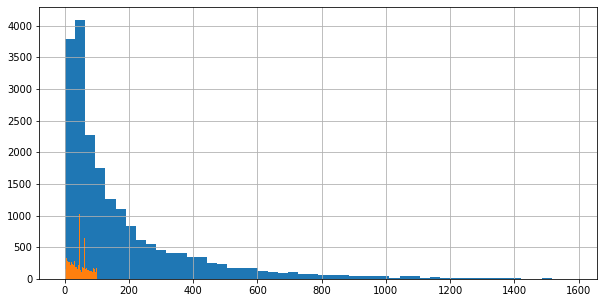

In [29]:
#изучите, как быстро продавались квартиры (столбец days_exposition)
data['days_exposition'].hist(bins=50, figsize=(10,5),range=(0, 1580))
data['days_exposition'].hist(bins=50, figsize=(10,5),range=(0, 100))
data['days_exposition'].loc[data['days_exposition'] < 77777777].describe()


Большая часть квартир продается в течение первых 50 дней, есть и квартиры, которые продавались до года, но самое интересное внутри 50 дней есть пик как раз на 50 и 60 дней. Скорей всего этому есть разумное объяснение, не связанное с реальной датой продажи(не стоит учитывать)

total_area корреляция Пирсона - 0.65


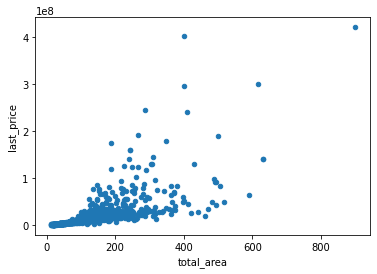

living_area корреляция Пирсона - 0.59


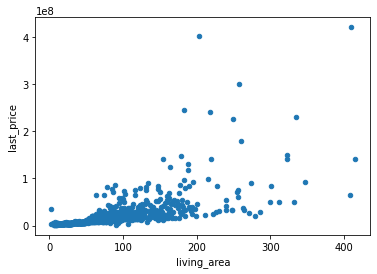

kitchen_area корреляция Пирсона - 0.49


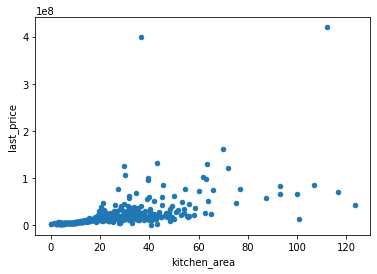

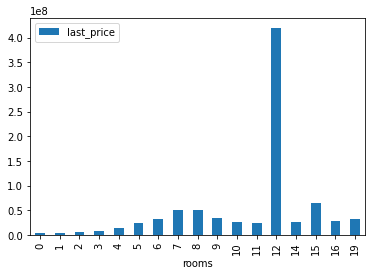

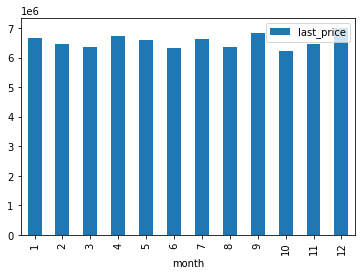

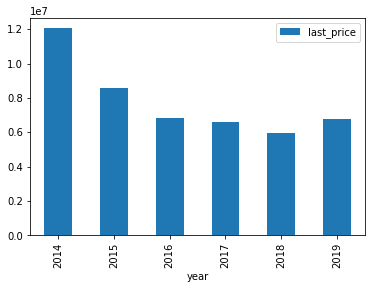

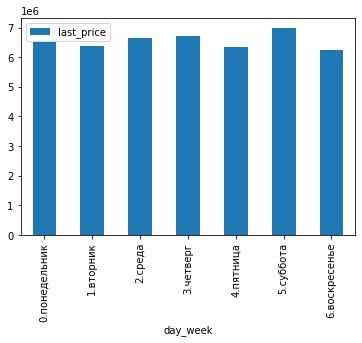

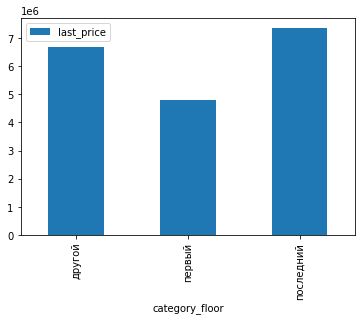

In [30]:
#какие факторы больше всего влияют на общую (полную) стоимость объекта
#список_количественные значения
list_params = ['total_area','living_area', 'kitchen_area']
for i in list_params:
    data.pivot_table(index=i, values='last_price').reset_index().plot(kind='scatter', x=i, y='last_price')
    print(i, 'корреляция Пирсона -', data['last_price'].corr(data[i]).round(2))
    plt.show()

#спиосок_категориальные значения
dict_params = ['rooms','month', 'year', 'day_week', 'category_floor']
for i in dict_params:
    data.pivot_table(index=i, values='last_price').reset_index().plot(kind='bar', x=i, y='last_price')
    plt.show()

Конечно площадь и кол-во комнат. Корреляция Пирсона это нам подтвердила еще раз. После исправления графиков в копилочку: этажность также влияет на цену. В нашем случае квартиры на последних этажа стоят дороже.

In [31]:
#посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
top10 = data['locality_name'].value_counts().head(10)
locality_pivot = (
    data.query('locality_name in @top10.index')
    .pivot_table(index = 'locality_name', values = 'price_one_meter')
)
locality_pivot.sort_values(by='price_one_meter', ascending=False).round(1)

,price_one_meter
locality_name,
санкт-петербург,114868.9
пушкин,103125.8
кудрово,95259.5
парголово,90177.2
мурино,86040.9
шушары,78552.0
колпино,75424.3
гатчина,68746.1
всеволожск,68655.4


Как и ожидалось, самые дорогие квартиры в Санкт-Петербурге и парковом городе Пушкине. Чем дальше от города, тем дешевле. В Выборге средняя цена за квадратный метр в 2 раз ниже, чем в Санкт-Петербурге

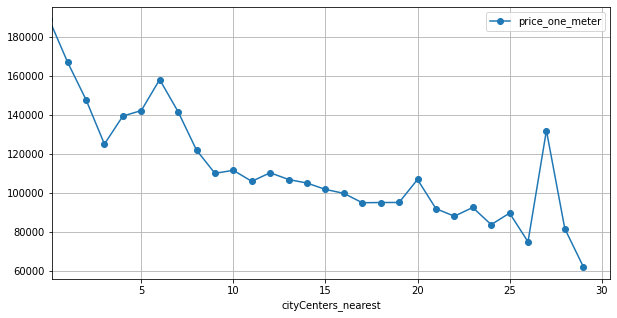

In [32]:
#выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра
data['cityCenters_nearest']=data['cityCenters_nearest'].astype('int64')
locality_pivot = (
    data.query('locality_name == "санкт-петербург"')
    .pivot_table(index = 'cityCenters_nearest', values = 'price_one_meter')
    .plot(grid=True, style='o-', xlim=(0.15), figsize=(10,5))
)
plt.show()

Квартиры, которые к ближе к центру мега дорогие.
Есть конечно пик возрастания стоимости на 27 км, но думаю это связано с наличием элитного района в данной области.


### Общий вывод

Чем больше площадь квартиры, тем выше цена	
Чем больше цена за квадратный метр, тем выше цена	
Чем выше доля жилой площади/площадь кухни, тем выше цена	
Чем больше комнат, тем выше цена	
Чем ближе к центру, тем дороже квартира